In [59]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import wfdb
import glob
import random
import warnings
import tempfile
import shutil
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter, lfilter, filtfilt, savgol_filter

FOLDER_PATH = '24h-emgcg/'
FOLDER_SAMPLE = '24h-ecg-sample/'
FOLDER_NORMALIZE = '24h-ecg-normalized/'
FOLDER_FILTER = '24h-ecg-normalized-filter/'
PHYSIONET_PATH = 'cves/1.0.0/data/24h-electromyography'
PHYSIONET_DIR = 'cves'

# CONVERT TO p_signal FILES USING 2 CHANNEL ecg_0 vs ecg_1

In [57]:

record_files = [f for f in os.listdir(FOLDER_PATH) if f.endswith('.hea')]

# Initialize an array to hold the names of records missing .dat files
records_missing_dat = []

records_exist = []

records_header_error = []

for record_file in record_files:
    # Extract the base name of the record (without extension)
    record_name = os.path.splitext(record_file)[0]
    
    # Check if the corresponding .dat file exists
    if not os.path.exists(os.path.join(FOLDER_PATH, f"{record_name}.dat")):
        records_missing_dat.append(record_name)
        continue  # Skip to the next record
    
    # Define the path for the output .p_signal file
    output_file_path = os.path.join(FOLDER_PATH, f"{record_name}_p_signal.txt")
    
    # Check if the .p_signal file already exists
    if os.path.exists(output_file_path):
        records_exist.append(record_file)
        continue  # Skip to the next record if .p_signal file exists
    
    # Read the specified channels (0 and 1) from the record
    try:
        record = wfdb.rdrecord(os.path.join(FOLDER_PATH, record_name), channels=[0, 1])
    except Exception as e:
        # Check if the exception is related to file not found or header syntax error
        if isinstance(e, FileNotFoundError):
            records_missing_dat.append(record_name)
        else:
            print(f"Error processing {record_name}: {str(e)}")
            records_header_error.append(record_name)
        continue
    
    # Extract the signals for channels 0 and 1
    signals = record.p_signal
    
    # Write the signals to the output file
    with open(output_file_path, 'w') as file:
        for signal in signals:
            file.write(f"{signal[0]}\t{signal[1]}\n")

print("Conversion completed.")
if records_missing_dat:
    print("The following records were skipped due to missing .dat files:")
    print(records_missing_dat)
if records_header_error:
    print("The following records had header syntax errors:")
    print(records_header_error)
print(f"Number of records converted: {len(record_files) - len(records_missing_dat) - len(records_header_error)}")

Conversion completed.
Number of records converted: 0


# DELETE ALL .dat .hea .maker files

In [58]:

extensions = ['.dat', '.hea', '.marker']

# Function to check for corresponding _p_signal.txt file and delete if exists
def delete_files_if_txt_exists(folder_path):
    for ext in extensions:
        file_pattern = os.path.join(folder_path, f'*{ext}')
        files = glob.glob(file_pattern)
        for file_path in files:
            # Construct the base name and check for the corresponding _p_signal.txt file
            base_name = os.path.splitext(os.path.basename(file_path))[0]
            txt_file_path = os.path.join(folder_path, f'{base_name}_p_signal.txt')
            if os.path.exists(txt_file_path):
                # Attempt to delete files with the specified extensions
                try:
                    os.remove(file_path)
                    print(f"Deleted: {file_path}")
                except OSError as e:
                    print(f"Error: {file_path} - {e.strerror}")

delete_files_if_txt_exists(FOLDER_PATH)

# CONVERT BY CALL PHYSIONET

In [6]:

os.makedirs(FOLDER_PATH, exist_ok=True)

for record_name in record_files:
    # Define the path for the expected .p_signal output file
    output_file_path = os.path.join(FOLDER_PATH, f"{record_name}_p_signal.txt")
    
    # Check if the .p_signal file already exists
    if os.path.exists(output_file_path):
        print(f"File {output_file_path} already exists. Skipping...")
        continue

    # Read the specified channels (0 and 1) from the record directly from PhysioNet
    # Note: This step requires an internet connection and access permissions to the data
    record = wfdb.rdrecord(record_name, pn_dir=PHYSIONET_PATH, channels=[0, 1])

    # Extract the signals for channels 0 and 1
    signals = record.p_signal

    # Write the signals to the output file
    with open(output_file_path, 'w') as file:
        for signal in signals:
            # Write each signal sample to the file, separated by a tab
            file.write(f"{signal[0]}\t{signal[1]}\n")

print("Conversion completed. Check the local directory for the .p_signal files.")


File 24h-emgcg/s0030-04051907_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0030-04051908_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0044-05062806_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0044-05062807_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0064-05081805_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0064-05081806_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0067-05040508_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0067-05040509_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0067-05040510_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0067-05040511_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0068-05022417_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0068-05022418_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0121-04042801_p_signal.txt already exists. Skipping...
File 24h-emgcg/s0121-04042802_p_signal.txt already exists. Skipping...
File 2

# CONVERT SIGNAL FROM uV to mV 

In [3]:

for filename in os.listdir(FOLDER_PATH):
    file_path = os.path.join(FOLDER_PATH, filename)
    # Check if it's a file
    if os.path.isfile(file_path):
        # Create a temporary file
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as temp_file:
            # Open the original file and read line by line
            with open(file_path, 'r') as file:
                for line in file:
                    values = line.split()
                    modified_values = [str(float(value)/1000) for value in values]
                    temp_file.write('\t'.join(modified_values) + '\n')

        # Manually copy the temporary file content to the original file
        shutil.copy(temp_file.name, file_path)
        
        # Remove the temporary file
        os.remove(temp_file.name)

print("All files have been modified.")


All files have been modified.


# Function get list of file names, plot data in range,...

In [60]:

def get_main_names_of_files(FOLDER_PATH):
    file_names = os.listdir(FOLDER_PATH)
    main_names = [name.split('_p_signal.txt')[0] for name in file_names if name.endswith('_p_signal.txt')]
    return main_names

# PLOT SIGNAL IN RANGE(m , n) BY FILENAME
def plot_ecg_signal(main_name_of_file, folder_path, n, m=0):
    # start m end n
    file_path = os.path.join(folder_path, f'{main_name_of_file}_p_signal.txt')
    
    if not os.path.exists(file_path):
        print(f'File {file_path} does not exist.')
        return
    
    try:
        # Load the data with a maximum of 'n' rows
        warnings.filterwarnings("ignore", message="Input line contained no data")
        total_data = np.loadtxt(file_path, max_rows=n)
        total_rows = total_data.shape[0]
        
        if m < 0 or n > total_rows or m >= n:
            raise ValueError(f"Invalid range: {m} to {n}. File contains {total_rows} rows.")
        
        # Since numpy.loadtxt doesn't support loading a slice directly, we use slicing after loading
        data_segment = total_data[m:n, :]
        
    except Exception as e:
        print(f"Error reading the file: {e}")
        return
    
    # Time array for the segment
    time = np.arange(m, n) * 1  # 1 ms per sample
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(time, data_segment[:, 0])
    plt.title('ECG Signal 1 Segment')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (mV)')
    
    plt.subplot(2, 1, 2)
    plt.plot(time, data_segment[:, 1])
    plt.title('ECG Signal 2 Segment')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (mV)')
    
    plt.tight_layout()
    plt.show()

def count_rows_in_file(prefix, directory):
    suffix = '_p_signal.txt'
    filename = prefix + suffix
    file_path = os.path.join(directory, filename)
    
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            return len(lines)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

names = get_main_names_of_files(FOLDER_PATH)

print("Main names of files:", names)


Main names of files: ['s0322-07052204', 's0242-06012405', 's0184-05091311', 's0335-07040503', 's0231-05111709', 's0175-05030325', 's0376-07091805', 's0221-06082208', 's0208-05102508', 's0153-05021018', 's0225-06022111', 's0218-05110113', 's0351-07062105', 's0230-06013111', 's0197-05060906', 's0358-07071203', 's0358-07071204', 's0247-06050205', 's0376-07091804', 's0221-06082209', 's0208-05102509', 's0184-05091310', 's0239-06012607', 's0164-06033006', 's0157-05062311', 's0322-07052205', 's0231-05111708', 's0232-06060108', 's0204-05092907', 's0230-06013110', 's0351-07062104', 's0354-07051506', 's0187-05040711', 's0164-06033107', 's0218-05110112', 's0331-07031501', 's0210-05092012', 's0153-05021019', 's0030-04051907', 's0132-04102801', 's0207-05090814', 's0215-06030712', 's0305-06113004', 's0361-07080906', 's0166-05031008', 's0352-07060705', 's0305-06113003', 's0214-05110807', 's0352-07060702', 's0154-05050307', 's0160-04052807', 's0174-05062113', 's0336-07041701', 's0348-07052402', 's0221

In [5]:
# COUNT NUMBER OF ROW EACH FILE

prefix = 's0402-08010704'
row_count = count_rows_in_file(prefix, FOLDER_PATH)

if row_count is not None:
    print(f"{prefix + '_p_signal.txt'}: {row_count} rows")
else:
    print(f"{prefix + '_p_signal.txt'}: File does not exist.")

s0402-08010704_p_signal.txt: 52072440 rows


In [61]:
# CREATE MAP OF NAME AND NUMBER OF ROW EACH FILE

MAP = {}
for name in names:
    row_count = count_rows_in_file(name, FOLDER_PATH)
    MAP[name + '_p_signal.txt'] = row_count

# PRINT AND SORT MAP ABOVE 
print("\nSorted by Value:")
sorted_by_value = dict(sorted(MAP.items(), key=lambda item: item[1]))
for name, count in sorted_by_value.items():
    print(f"{name}: {count} rows")


Sorted by Value:
s0164-06033005_p_signal.txt: 12 rows
s0221-06082203_p_signal.txt: 6888 rows
s0221-06082202_p_signal.txt: 6978 rows
s0221-06082204_p_signal.txt: 7650 rows
s0337-07032901_p_signal.txt: 9240 rows
s0221-06082208_p_signal.txt: 16164 rows
s0221-06082201_p_signal.txt: 16404 rows
s0337-07032903_p_signal.txt: 18996 rows
s0221-06082205_p_signal.txt: 21630 rows
s0321-07022204_p_signal.txt: 21912 rows
s0248-06041806_p_signal.txt: 25224 rows
s0337-07032902_p_signal.txt: 25500 rows
s0221-06082206_p_signal.txt: 35136 rows
s0247-06050206_p_signal.txt: 41886 rows
s0331-07031502_p_signal.txt: 49002 rows
s0067-05040509_p_signal.txt: 49530 rows
s0352-07060701_p_signal.txt: 52584 rows
s0277-06090701_p_signal.txt: 56850 rows
s0321-07022202_p_signal.txt: 72534 rows
s0331-07031503_p_signal.txt: 80868 rows
s0352-07060702_p_signal.txt: 81714 rows
s0336-07041701_p_signal.txt: 95466 rows
s0321-07022201_p_signal.txt: 128148 rows
s0321-07022203_p_signal.txt: 132966 rows
s0331-07031501_p_signal.txt

# RAMDOMLY SAMPLE 100 NON-OVERLAPPING SEGMENTS EACH SIGNAL 

In [29]:
sampling_rate = 1000  # Adjust this as per your file specifics
segment_length_ms = 6000
segment_length_samples = int(sampling_rate * (segment_length_ms / 1000))

max_segments = 100

# Process each file in the directory
for filename in os.listdir(FOLDER_PATH):
    if filename.endswith('.txt') and 'p_signal' in filename:
        file_path = os.path.join(FOLDER_PATH, filename)
        output_base_filename = filename.replace('_p_signal.txt', '')

        # Read the entire data file
        with open(file_path, 'r') as file:
            data = file.readlines()

        # Calculate the maximum number of segments we can have
        possible_segments = min(max_segments, len(data) // segment_length_samples)

        # Calculate start points for each segment
        start_indices = sorted(random.sample(range(0, len(data) - segment_length_samples + 1), possible_segments))

        # Extract and write each segment to a separate compressed file
        for i, start in enumerate(start_indices):
            segment = data[start:start + int(segment_length_samples)]
            segment_filename = f"{output_base_filename}_{i + 1}_p_signal.txt"
            segment_file_path = os.path.join(FOLDER_SAMPLE, segment_filename)

            with open(segment_file_path, 'w') as outfile:
                outfile.writelines(segment)

        print(f"Processed {filename} into {possible_segments} segments.")

print("Sampling complete.")

Processed s0322-07052204_p_signal.txt into 100 segments.
Processed s0242-06012405_p_signal.txt into 100 segments.
Processed s0184-05091311_p_signal.txt into 100 segments.
Processed s0335-07040503_p_signal.txt into 100 segments.
Processed s0231-05111709_p_signal.txt into 100 segments.
Processed s0175-05030325_p_signal.txt into 100 segments.
Processed s0376-07091805_p_signal.txt into 100 segments.
Processed s0221-06082208_p_signal.txt into 2 segments.
Processed s0208-05102508_p_signal.txt into 100 segments.
Processed s0153-05021018_p_signal.txt into 100 segments.
Processed s0225-06022111_p_signal.txt into 100 segments.
Processed s0218-05110113_p_signal.txt into 100 segments.
Processed s0351-07062105_p_signal.txt into 100 segments.
Processed s0230-06013111_p_signal.txt into 100 segments.
Processed s0197-05060906_p_signal.txt into 100 segments.
Processed s0358-07071203_p_signal.txt into 100 segments.
Processed s0358-07071204_p_signal.txt into 100 segments.
Processed s0247-06050205_p_signal

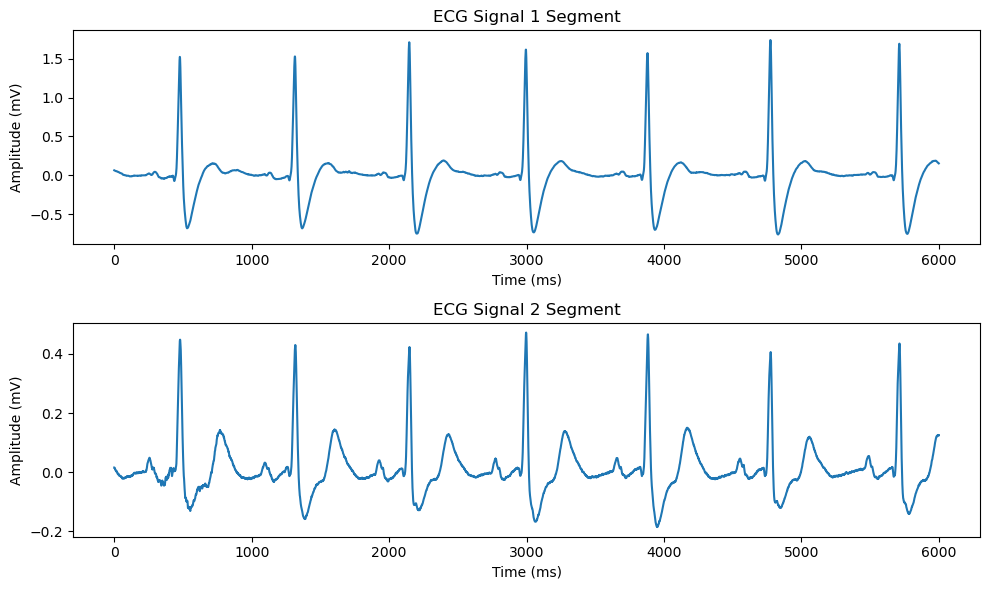

In [64]:
# CHECK DATA BY PLOT SIGNAL

# plot_ecg_signal('s0402', FOLDER_SAMPLE, 40000, 34000)
plot_ecg_signal('s0402-08010704_1', FOLDER_SAMPLE, 6000)
# plot_ecg_signal('s0402-08010704', FOLDER_PATH, 50000000)

# NORMALIZED DATA AFTER SAMPLING

In [33]:
source_directory = FOLDER_SAMPLE # Replace with your actual path
destination_directory = FOLDER_NORMALIZE

scaler = MinMaxScaler()

# Process each file in the source directory
for filename in os.listdir(source_directory):
    if filename.endswith('.txt'):
        file_path = os.path.join(source_directory, filename)
        
        # Load the data from the file
        data = np.loadtxt(file_path)

        # Check if the data is in two columns or a single column
        if data.ndim == 1:
            # If it's a single column, reshape it for the scaler
            data = data.reshape(-1, 1)

        # Apply the MinMaxScaler to the data
        normalized_data = scaler.fit_transform(data)
        
        # Save the normalized data to a new file in the destination folder
        dest_file_path = os.path.join(destination_directory, filename)
        np.savetxt(dest_file_path, normalized_data)

print("All files have been normalized.")

All files have been normalized.


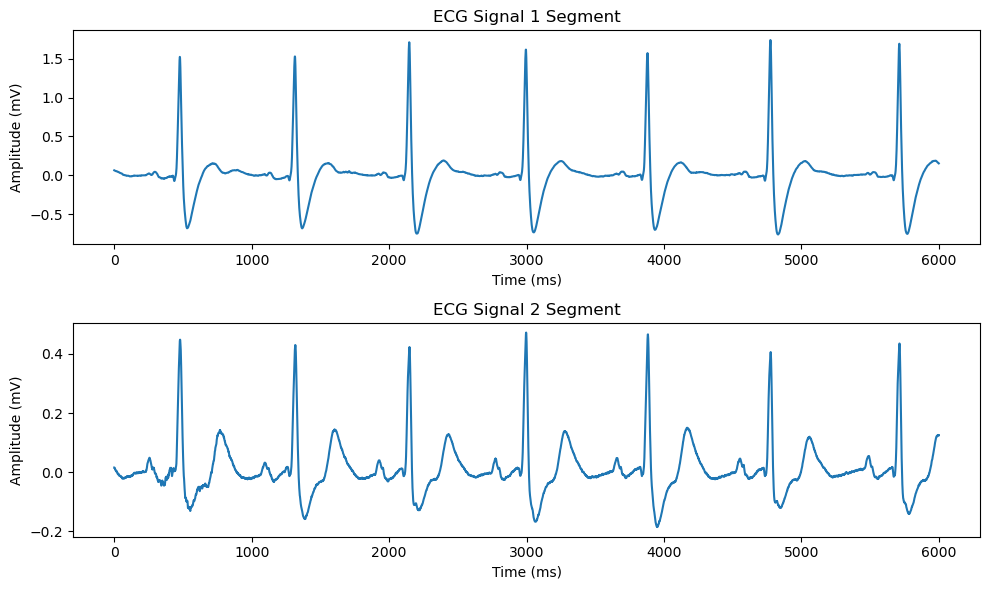

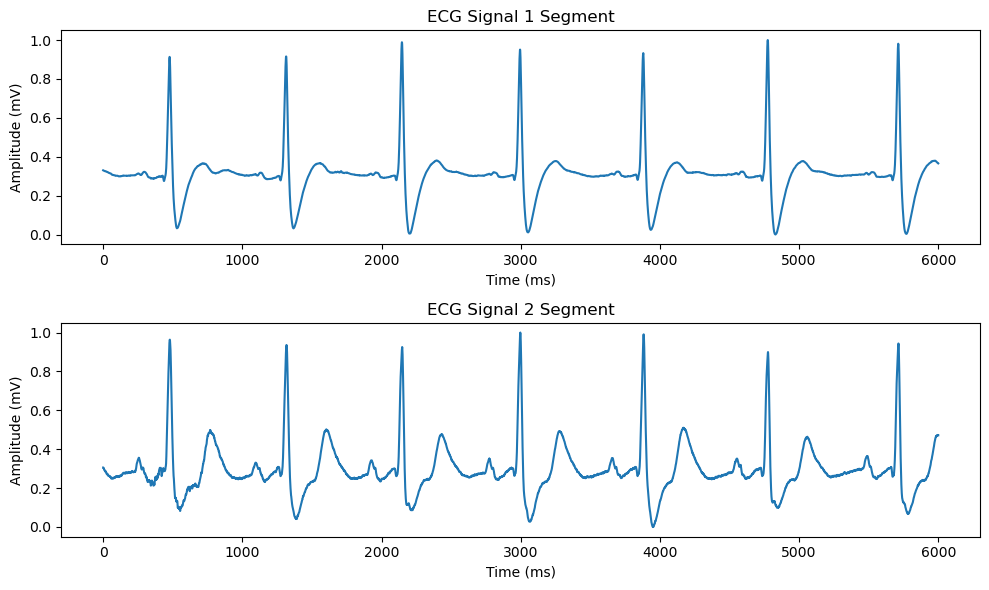

In [65]:
# CHECK DATA BY PLOT SIGNAL

plot_ecg_signal('s0402-08010704_1', FOLDER_SAMPLE, 6000)
plot_ecg_signal('s0402-08010704_1', FOLDER_NORMALIZE, 6000)

In [40]:

# Define the source and destination directories
source_directory = FOLDER_NORMALIZE 
destination_directory = FOLDER_FILTER

cutoff_frequency = 11  # Cutoff frequency in Hz
sampling_rate = 1000  # Sampling rate in Hz
order = 2  # Order of the polynomial

# Butterworth filter design
b, a = butter(order, cutoff_frequency / (0.5 * sampling_rate), btype='low')

# Function to apply the low-pass filter
def low_pass_filter(signal):
    return filtfilt(b, a, signal)

# Function to compute derivatives
def compute_derivatives(signal):
    first_derivative = np.gradient(signal, 10)  # Change in signal for every 10 samples
    second_derivative = np.gradient(first_derivative, 10)
    return first_derivative, second_derivative

# Process each normalized signal file
for filename in os.listdir(source_directory):
    if filename.endswith('p_signal.txt'):
        source_file_path = os.path.join(source_directory, filename)
        destination_file_path = os.path.join(destination_directory, filename)
        
        # Read the normalized data from the file
        data = np.loadtxt(source_file_path)
        
        # Apply the low-pass filter to the data
        smoothed_data = low_pass_filter(data)
        
        # Isolate high-frequency signals
        high_freq_data = data - smoothed_data
        
        # Compute the first and second derivatives
        first_derivative, second_derivative = compute_derivatives(smoothed_data)
        
        # Write the smoothed data, high-frequency data, and derivatives to a new file
        with open(destination_file_path, 'w') as file:
            for i in range(len(data)):
                file.write(f"{smoothed_data[i]}\t{high_freq_data[i]}\t{first_derivative[i]}\t{second_derivative[i]}\n")

print("Filtering and derivative computation complete.")

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 5998 and the array at index 2 has size 5999

[ 1.         -1.90232894  0.90688161]
[0.00113817 0.00227633 0.00113817]


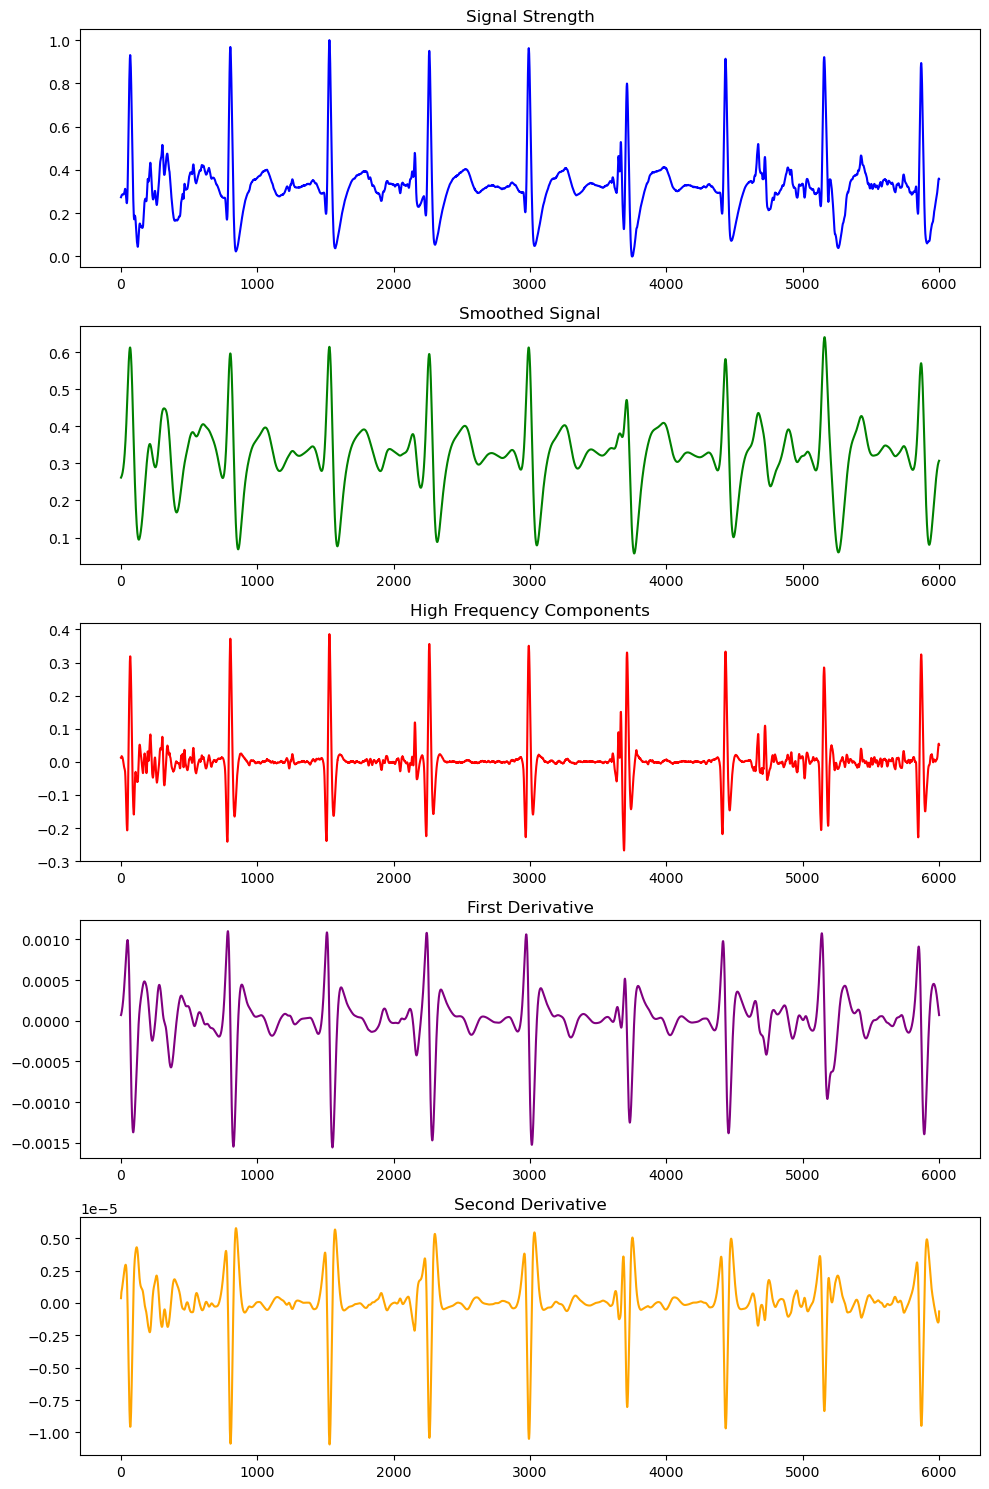

<Figure size 640x480 with 0 Axes>

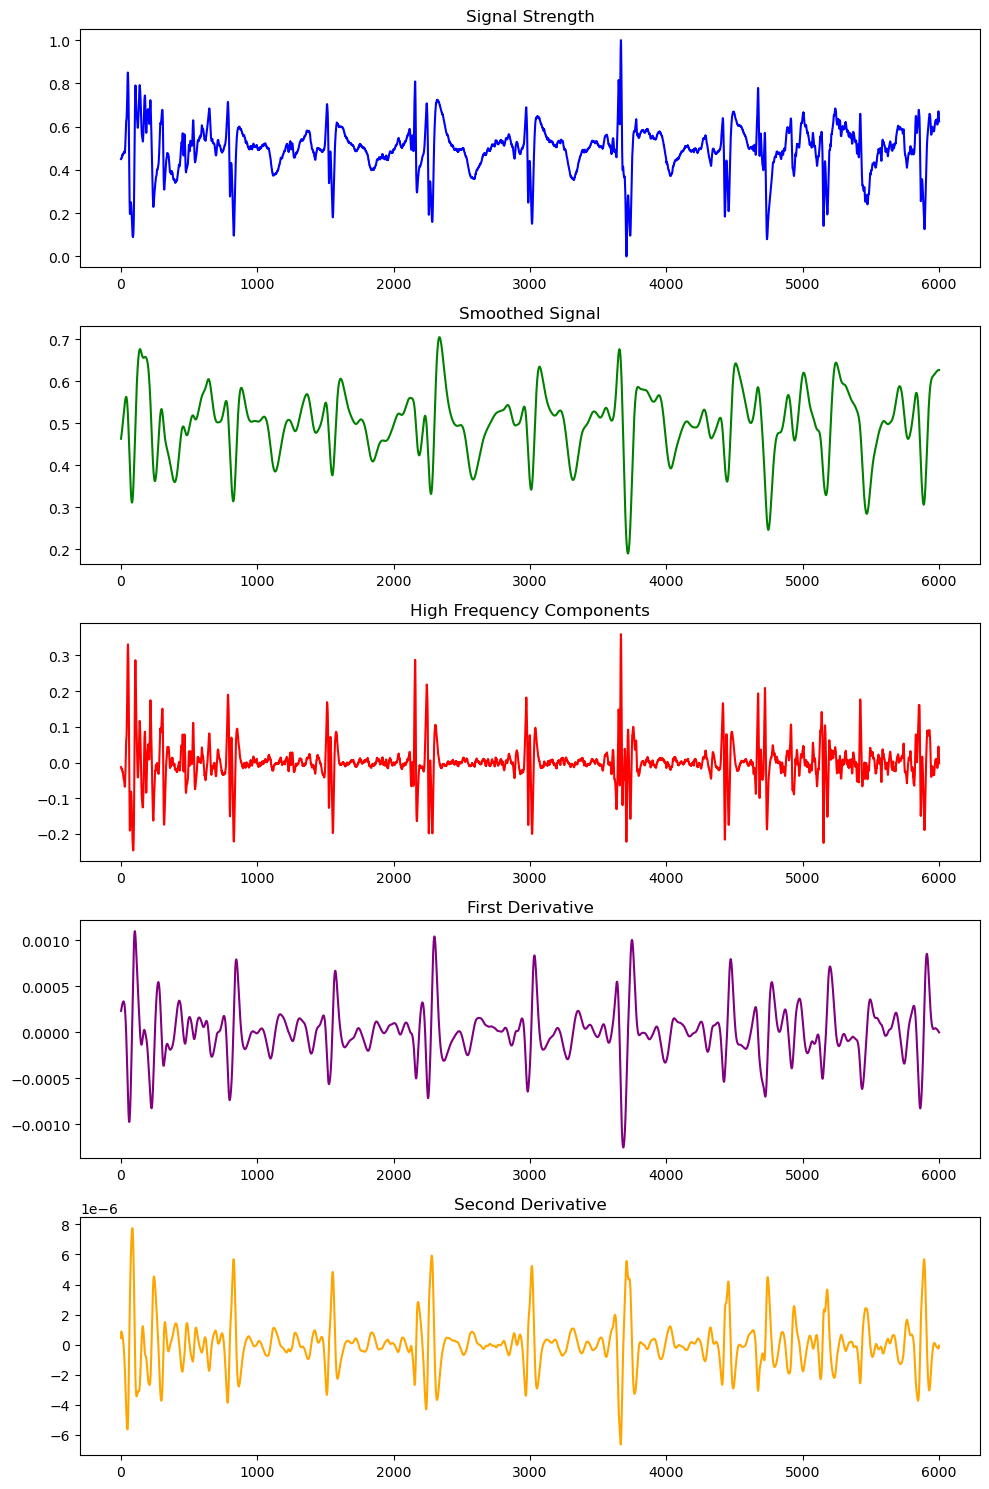

<Figure size 640x480 with 0 Axes>

In [67]:

cutoff_frequency = 11  # Cutoff frequency in Hz
sampling_rate = 1000  # Sampling rate in Hz
order = 2  # Order of the polynomial

# divide by (0.5 * sampling_rate)
# frequencies are often normalized by the Nyquist frequency
# which is half the sampling rate. 
# The Nyquist frequency is the highest frequency that can be effectively 
# sampled without introducing aliasing according to the Nyquist-Shannon sampling theorem.
b, a = butter(order, cutoff_frequency / (0.5 * sampling_rate), btype='low')
print(a)
print(b)

# Function to apply the low-pass filter
def low_pass_filter(signal):
    return filtfilt(b, a, signal)

# Function to compute derivatives
def compute_derivatives(signal):
    first_derivative = np.gradient(signal, 10)  # Change in signal for every 10 samples
    second_derivative = np.gradient(first_derivative, 10)
    return first_derivative, second_derivative

def extract_columns(file_name):
    full_file_path = os.path.join(FOLDER_NORMALIZE, file_name)
    
    data = np.loadtxt(full_file_path)
    
    left = data[:, 0]
    right = data[:, 1]    
    return left, right

def plot(name):
    ss, sss = extract_columns(name)
    pp(ss)
    pp(sss)
    
def pp(ss):
    
    smooth = filtfilt(b, a, ss)
    high_freq_data = ss - smooth       
    first_derivative, second_derivative = compute_derivatives(smooth)
    plt.figure(figsize=(10, 15)) 

    colors = ['blue', 'green', 'red', 'purple', 'orange']

    plt.subplot(5, 1, 1)
    plt.plot(ss, color=colors[0])
    plt.title('Signal Strength')

    plt.subplot(5, 1, 2)
    plt.plot(smooth, color=colors[1]) 
    plt.title('Smoothed Signal')

    plt.subplot(5, 1, 3)
    plt.plot(high_freq_data, color=colors[2])
    plt.title('High Frequency Components')

    plt.subplot(5, 1, 4)
    plt.plot(first_derivative, color=colors[3])
    plt.title('First Derivative')

    plt.subplot(5, 1, 5)
    plt.plot(second_derivative, color=colors[4])
    plt.title('Second Derivative')

    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.show()
    
plot('s0030-04051907_15_p_signal.txt')
# print(smooth, " = ", len(smooth))
# print(high_freq_data, " = ", len(high_freq_data))
# print(first_derivative, " = ", len(first_derivative))
# print(second_derivative, " = ", len(second_derivative))
